In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import joblib

In [3]:
import pandas as pd

In [4]:
from kid_readout import *
from kid_readout.measurement import mmw_source_sweep, temperature

In [5]:
import glob

In [6]:
fns = glob.glob('/artemis/readout/2016-04-2*.nc')
fns.sort()

In [7]:
memory = joblib.Memory(cachedir='/home/gjones/pipeline_cache',mmap_mode='c',verbose=5)

In [18]:
memory.clear()

In [19]:
#@memory.cache
def process_one(fn):
    ncf = NCFile(fn)
    off_stream = None
    on_stream = None
    sweep = None
    mod_stream = None
    for name in ncf.measurement_names():
        meas = ncf.read(name)
        if name.startswith('Sweep'):
            sweep = meas
        else:
            modulation = meas.stream(0).roach_state.modulation_output 
            #print name, modulation
            if modulation == 0:
                on_stream = meas
            elif modulation == 1:
                off_stream = meas
            elif modulation == 2:
                mod_stream = meas
    if on_stream is None:
        on_stream = off_stream
        off_stream = None
    if on_stream is not None:
        meas = mmw_source_sweep.MMWSweepOnMod(ncf.SweepArray0,on_stream = on_stream, off_stream = off_stream, mod_stream = mod_stream)
        measurement.temperature.add_temperature(meas,'starcryo',recursive=True)
        rows = meas.to_dataframe(add_origin=True)
    else:
        rows = None
    ncf.close()
    return rows

In [17]:
%time rows = process_one('/artemis/readout/2016-04-20_044055_off_on_modulated_10_dB_dac.nc')

StreamArray1 1
StreamArray2 2
updated file list


/home/gjones/anaconda/envs/readout/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


KeyboardInterrupt: 

In [13]:
rows

In [9]:
ncf = NCFile(fns[-1])

In [66]:
ncf.measurement_names()

[u'SweepArray0', u'StreamArray1', u'StreamArray2', u'StreamArray3']

In [86]:
meas = ncf.read('StreamArray1')

In [88]:
state = meas.stream(0).roach_state

In [89]:
state

StateDict({u'boffile': u'iq2xpfb14mcr7_2015_Nov_25_0907.bof', u'num_filterbank_channels': 16384, u'loopback': None, u'lo_frequency': 1570000000.0, u'adc_sample_rate': 512000000.0, u'num_tones': 32, u'waveform_normalization': 0.0003662109375, u'modulation_output': 1, u'modulation_rate': 0, u'debug_register': None, u'num_tone_samples': 65536, u'bank': 97, u'dac_attenuation': 2.0, u'heterodyne': True})

In [82]:
state.

StateDict({u'mmwave_source': StateDict({u'ttl_modulation_source': u'roach', u'multiplier_input': u'thermal', u'mickey_ticks': 125.0, u'minnie_ticks': 125.0, u'before_multiplier': None, u'waveguide_twist_angle': 45, u'multiplier_factor': 12.0, u'after_multiplier': u'bpf_140_160_GHz'}), u'lockin': StateDict({u'input_coupling': 1, u'sine_output_voltage': 0.87, u'sensitivity': 17, u'reference_frequency': 122.071, u'input_configuration': 0, u'reference_phase': -172.0, u'output_filter_slope': 1, u'reference_source': 0, u'reference_trigger': 2, u'rms_voltage': 0.0010921399999999999, u'sync_filter': False, u'reserve_mode': 2, u'input_shield_grounding': 0, u'signal_phase': -2.25, u'detection_harmonic': 1, u'identification': [u'Stanford_Research_Systems', u'SR830', u's/n45571', u'ver1.07'], u'sample_rate': 4, u'input_notch_filter': 1, u'time_constant': 8, u'local': 0}), u'signal_conditioner': StateDict({u'adc_chain_gain': 0.0, u'description': u'Mark I 1-2 GHz', u'dac_chain_gain': -39})})

In [19]:
rows

In [20]:
parp = joblib.Parallel(n_jobs=8,verbose=10)

In [ ]:
all_rows = parp(joblib.delayed(memory.cache(process_one))(fn) for fn in fns)


________________________________________________________________________________
[Memory] Calling __main__--data-home-gjones-notebooks-2016-__ipython-input__.process_one...
process_one('/artemis/readout/2016-04-20_000426_off_on_modulated_20_dB_dac.nc')________________________________________________________________________________
[Memory] Calling __main__--data-home-gjones-notebooks-2016-__ipython-input__.process_one...
process_one('/artemis/readout/2016-04-20_000644_off_on_modulated_6_dB_dac.nc')________________________________________________________________________________
[Memory] Calling __main__--data-home-gjones-notebooks-2016-__ipython-input__.process_one...
process_one('/artemis/readout/2016-04-20_000536_off_on_modulated_10_dB_dac.nc')

________________________________________________________________________________
[Memory] Calling __main__--data-home-gjones-notebooks-2016-__ipython-input__.process_one...
process_one('/artemis/readout/2016-04-20_000756_off_on_modulated_2_dB_

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  4.5min


____________________________________________________process_one - 268.3s, 4.5min
[Memory]  268.4s, 4.5min: Loading process_one...
________________________________________________________________________________
[Memory] Calling __main__--data-home-gjones-notebooks-2016-__ipython-input__.process_one...
process_one('/artemis/readout/2016-04-20_002406_off_on_modulated_2_dB_dac.nc')
____________________________________________________process_one - 269.4s, 4.5min
________________________________________________________________________________
[Memory] Calling __main__--data-home-gjones-notebooks-2016-__ipython-input__.process_one...
process_one('/artemis/readout/2016-04-20_002529_off_on_modulated_20_dB_dac.nc')[Memory]  269.5s, 4.5min: Loading process_one...

____________________________________________________process_one - 270.2s, 4.5min
[Memory]  270.3s, 4.5min: Loading process_one...
____________________________________________________process_one - 270.5s, 4.5min
[Memory]  270.6s, 4.5min

In [14]:
1

1

In [ ]:
len(all_rows)

In [16]:
%time df = pd.concat(all_rows,ignore_index=True)

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


In [17]:
df.shape

(13824, 91)

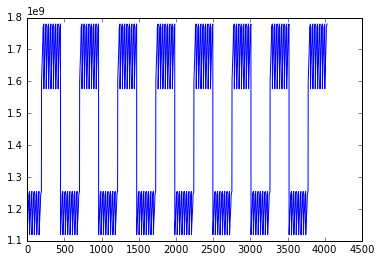

In [53]:
plot(df.res_f_0)

In [18]:
df['resonator_index'] = df.number + 24*(df.res_f_0>1.4e9)

In [19]:
dd.shape

NameError: name 'dd' is not defined

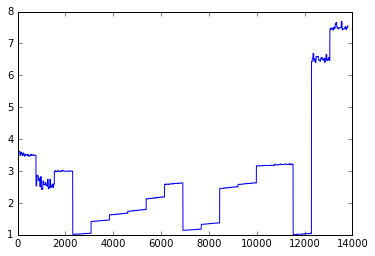

In [20]:
plot(df.temperature_primary_load)

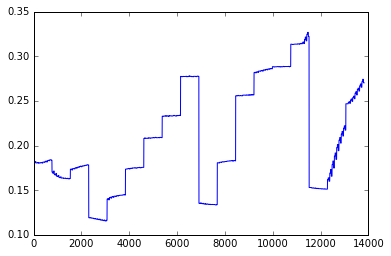

In [21]:
plot(df.temperature_primary_package)

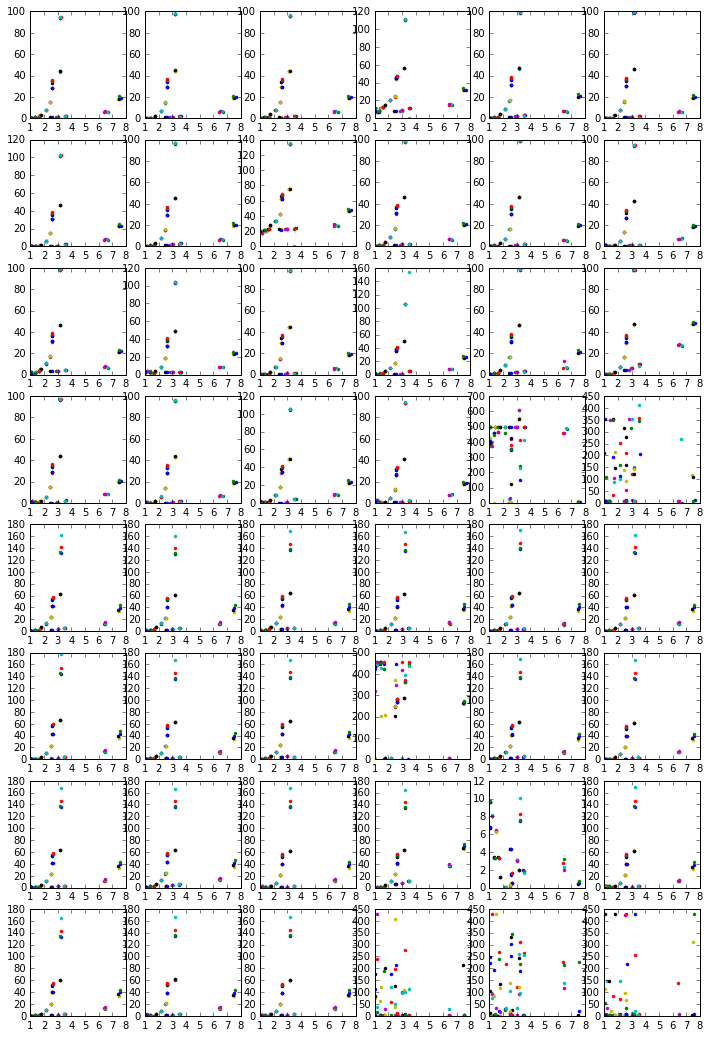

In [22]:
dd = df[df.roach_modulation_output==1]
fig,axs = subplots(8,6,figsize=(12,18))
for k,row in dd.iterrows():
    if row.number >= 24:
        continue
    ax =axs.flatten()[row.resonator_index]
    f0max = dd[dd.resonator_index==row.resonator_index].res_f_0.max()
    ax.plot(row.temperature_primary_load,1e6*(1-row.res_f_0/f0max),'.')

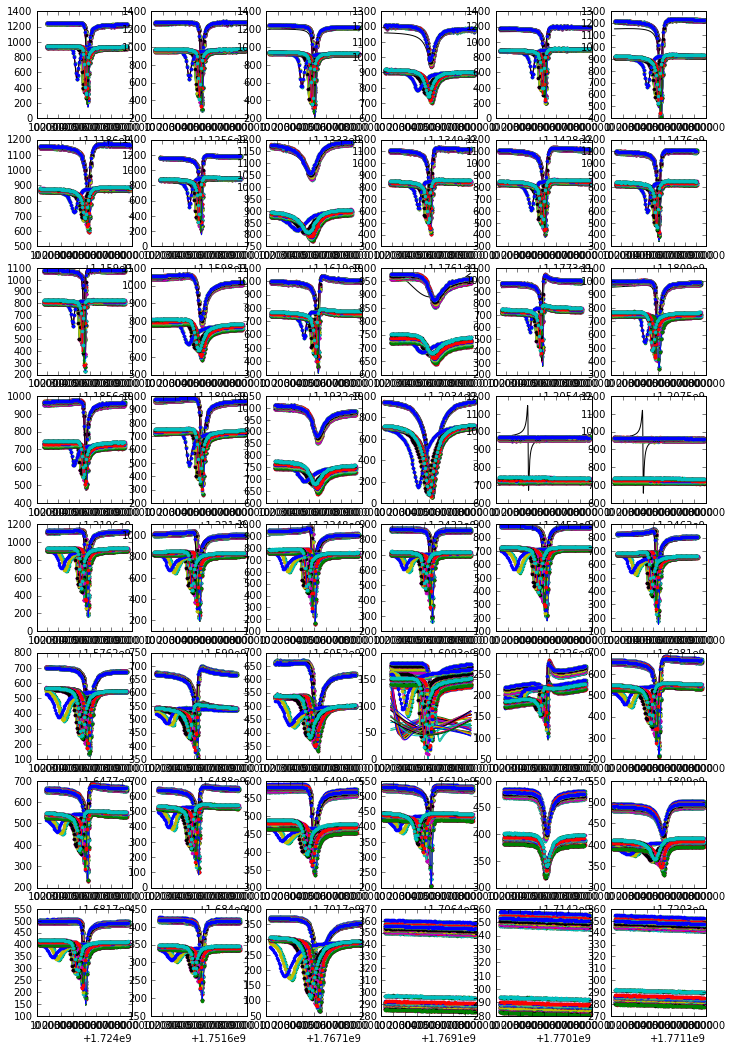

In [23]:
dd = df[df.roach_modulation_output==1]
fig,axs = subplots(8,6,figsize=(12,18))
for k,row in dd.iterrows():
    if row.number >= 24:
        continue
    ax =axs.flatten()[row.resonator_index]
    ax.plot(row.res_model_frequency,np.abs(row.res_model_s21))
    ax.plot(row.res_frequency_data,np.abs(row.res_s21_data),'.')

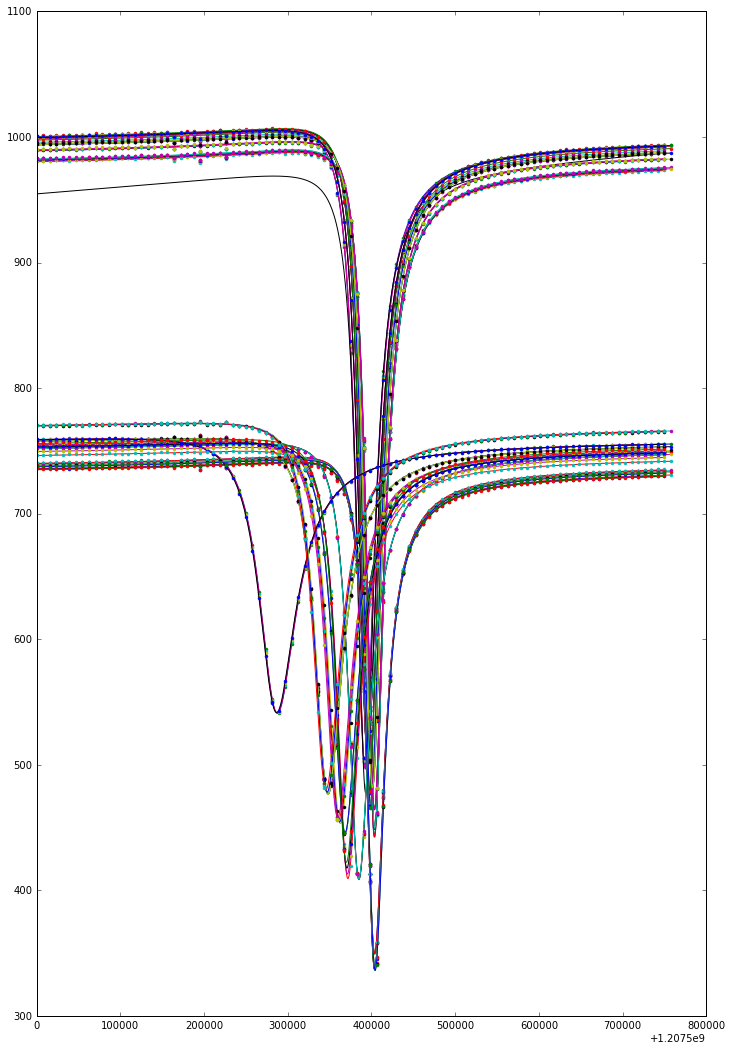

In [24]:
dd = df[(df.roach_modulation_output==1) & (df.resonator_index==17)]
fig,axs = subplots(1,1,figsize=(12,18))
for k,row in dd.iterrows():
    #if row.number >= 24:
    #    continue
    ax =axs
    ax.plot(row.res_model_frequency,np.abs(row.res_model_s21))
    ax.plot(row.res_frequency_data,np.abs(row.res_s21_data),'.')

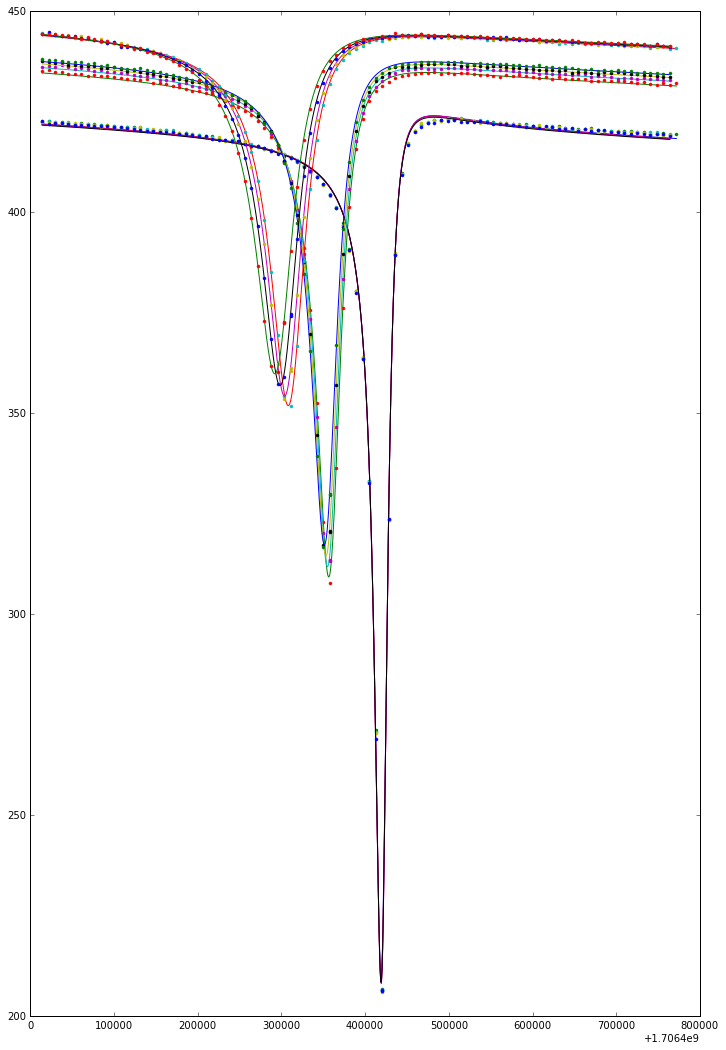

In [37]:
dd = df[(df.roach_modulation_output==1) & (df.resonator_index==15+24) & (df.mmwave_source_mickey_ticks<150)]
fig,axs = subplots(1,1,figsize=(12,18))
for k,row in dd.iterrows():
    #if row.number >= 24:
    #    continue
    ax =axs
    ax.plot(row.res_model_frequency,np.abs(row.res_model_s21))
    ax.plot(row.res_frequency_data,np.abs(row.res_s21_data),'.')

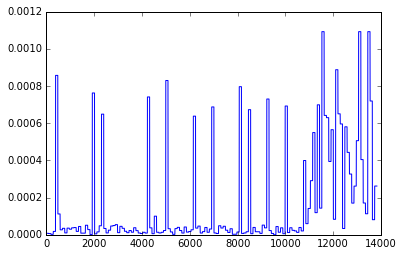

In [59]:
plot(df.lockin_rms_voltage)

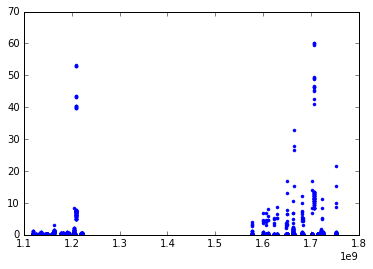

In [92]:
dd = df[(df.roach_modulation_output==2) & (df.number < 20)]
plot(dd.res_f_0,[1e6*row.folded_x.ptp() for k,row in dd.iterrows()],'.')

(-1e-08, 1e-08)

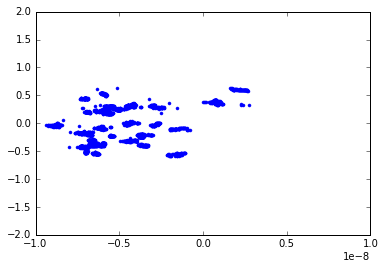

In [106]:
plot(dd.res_delay,np.angle(dd.res_Q_e),'.')
xlim(-1e-8,1e-8)

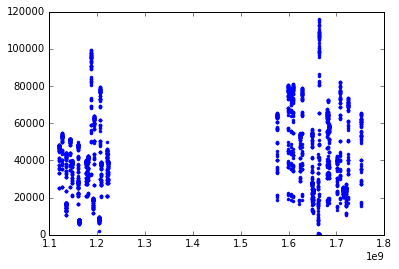

In [97]:
plot(dd.res_f_0,dd.res_Q,'.')

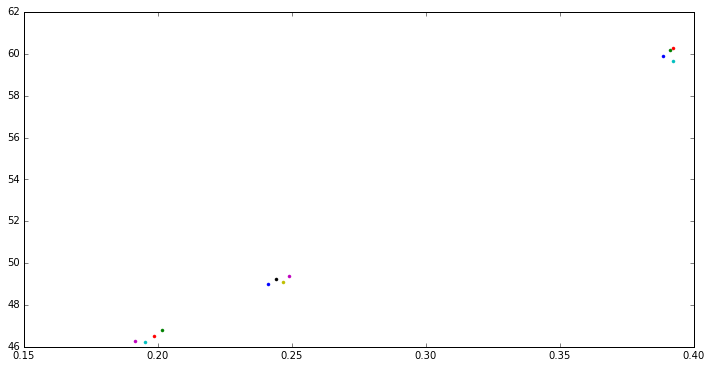

In [88]:
dd = df[(df.roach_modulation_output==2) & (df.resonator_index==15+24) & (df.mmwave_source_mickey_ticks<150)
       & (df.temperature_primary_package < 0.3)]
fig,axs = subplots(1,1,figsize=(12,6))
for k,row in dd.iterrows():
    #if row.number >= 24:
    #    continue
    ax =axs
    #ax.plot(1e6*(1-row.res_f_0/df.res_f_0.max()),1e6*row.folded_x.ptp(),'.')
    ax.plot((1e6/row.res_Q_i)**-.5,1e6*row.folded_x.ptp(),'.')

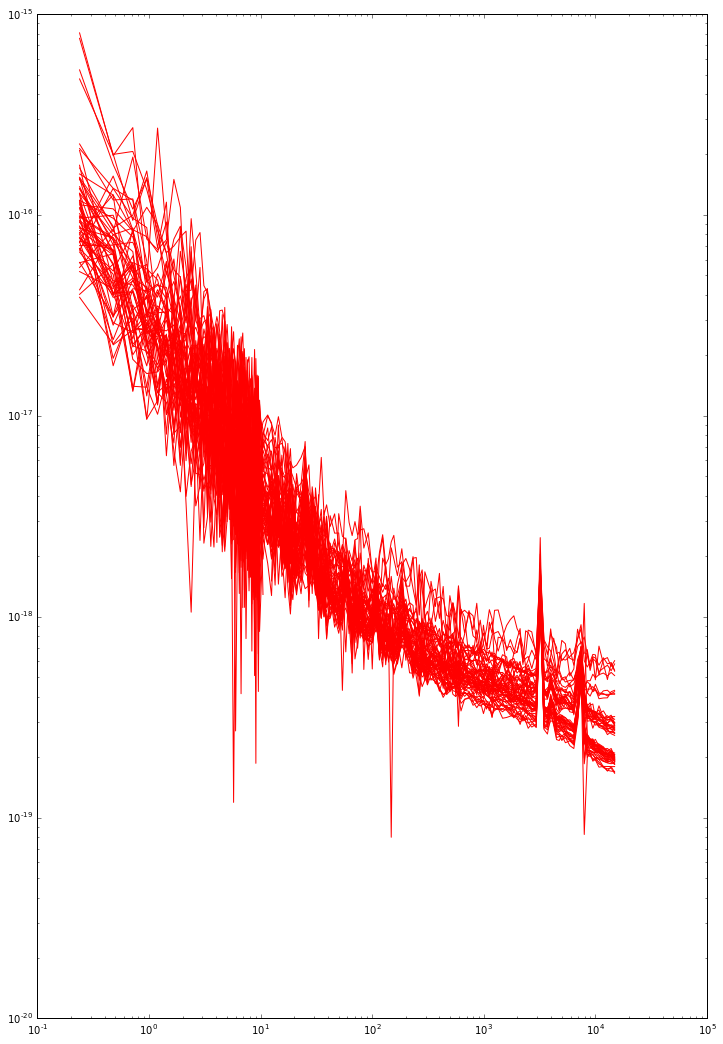

In [50]:
dd = df[(df.roach_modulation_output==1) & (df.resonator_index==17) & (df.mmwave_source_mickey_ticks>150)]
fig,axs = subplots(1,1,figsize=(12,18))
for k,row in dd.iterrows():
    #if row.number >= 24:
    #    continue
    ax =axs
    ax.loglog(row.S_frequency[1:],row.S_xx[1:]-row.S_yy[1:],'r')
#    ax.loglog(row.S_frequency[1:],row.S_yy[1:],'k')
    
#    ax.plot(row.res_model_frequency,np.abs(row.res_model_s21))
#    ax.plot(row.res_frequency_data,np.abs(row.res_s21_data),'.')

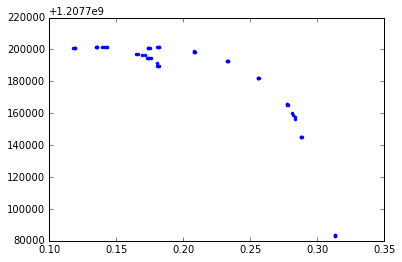

In [47]:
plot(dd.temperature_primary_package,dd.res_f_0,'.')

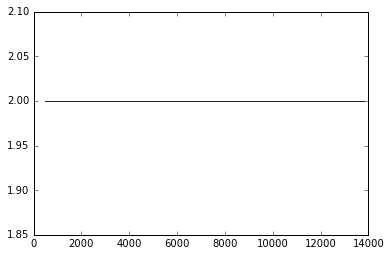

In [30]:
plot(dd.roach_dac_attenuation)

In [31]:
df.roach_dac_attenuation.value_counts()

2.0    13824
Name: roach_dac_attenuation, dtype: int64

In [32]:
fns[-1]

'/artemis/readout/2016-04-23_231033_off_on_modulated_broadband_2_dB_dac.nc'

In [34]:
df.mmwave_source_mickey_ticks.value_counts()

175.0    11520
125.0     2304
Name: mmwave_source_mickey_ticks, dtype: int64